In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from glob import glob

import matplotlib as mpl
import matplotlib.pyplot as plt
from fastcore.xtras import load_pickle

import matplotx
import numpy as np
import pandas as pd

from scipy.stats import sem

from gptchem.plotsettings import *

%matplotlib inline

In [3]:
all_res = glob("out/**/*.pkl")

In [4]:
compiled_res = []
compiled_gpr = []

for res in all_res:
    loaded = load_pickle(res)
    repre = loaded["representation"]
    num_points = loaded["num_train_points"]

    metrics = {
        "representation": loaded["representation"],
        "num_train_points": loaded["num_train_points"],
        "mae": loaded["mean_absolute_error"],
        "max_error": loaded["max_error"],
        "mse": loaded["mean_squared_error"],
    }

    compiled_res.append(metrics)

    gpr_metrics = {
        "num_train_points": loaded["num_train_points"],
        "mae": loaded["gpr_baseline"]["mean_absolute_error"],
        "max_error": loaded["gpr_baseline"]["max_error"],
        "mse": loaded["gpr_baseline"]["mean_squared_error"],
    }

    compiled_gpr.append(gpr_metrics)

In [5]:
compiled_res = pd.DataFrame(compiled_res)
compiled_gpr = pd.DataFrame(compiled_gpr)

In [6]:
compiled_grouped_res = compiled_res.groupby(["representation", "num_train_points"]).agg(
    ["mean", "std", sem]
)

In [7]:
compiled_gpr_grouped = compiled_gpr.groupby(["num_train_points"]).agg(["mean", "std", sem])

In [8]:
compiled_grouped_res

mae                     max_error  \
                                     mean       std       sem      mean   
representation num_train_points                                           
InChI          10                2.610160  0.394653       NaN  7.997143   
               50                2.367311  0.216048       NaN  7.970000   
               100               2.211586  0.136786       NaN  7.517857   
               200               2.107451  0.113085  0.029199  7.549333   
               500               2.000869  0.102287  0.027337  6.857857   
SELFIES        10                2.524674  0.458004       NaN  7.648571   
               50                2.274582  0.177595  0.044399  7.838125   
               100               2.251615  0.123429  0.030857  7.760625   
               200               2.167741  0.114580  0.029584  7.924667   
               500               2.110317  0.112621  0.029078  7.672667   
SMILES         10                2.621650  0.457843       NaN  7.805556   
               50                2.456904  0.203329       NaN  7.906000   
               100               2.265451  0.204602       NaN  7.871667   
               200               2.121658  0.084320       NaN  7.723889   
               500               1.973207  0.104416  0.025325  7.224706   

                                                           mse            \
                                      std       sem       mean       std   
representation num_train_points                                            
InChI          10                1.159320       NaN  10.134787  2.928551   
               50                1.102694       NaN   8.481147  1.439966   
               100               1.181812       NaN   7.524293  1.002959   
               200               0.933599  0.241054   6.838062  0.876185   
               500               0.613843  0.164056   6.256196  0.674017   
SELFIES        10                0.726279       NaN   9.578248  3.150005   
               50                0.905761  0.226440   7.963748  1.326165   
               100               0.915478  0.228869   7.771429  1.036726   
               200               0.887974  0.229274   7.266194  0.864150   
               500               0.845885  0.218406   7.079091  0.801550   
SMILES         10                1.109400       NaN  10.203179  3.386514   
               50                1.150315       NaN   9.117316  1.436166   
               100               0.794142       NaN   7.816232  1.453104   
               200               0.766636       NaN   6.999448  0.507148   
               500               0.718045  0.174152   6.249430  0.720548   

                                           
                                      sem  
representation num_train_points            
InChI          10                     NaN  
               50                     NaN  
               100                    NaN  
               200               0.226230  
               500               0.180139  
SELFIES        10                     NaN  
               50                0.331541  
               100               0.259181  
               200               0.223123  
               500               0.206959  
SMILES         10                     NaN  
               50                     NaN  
               100                    NaN  
               200                    NaN  
               500               0.174759

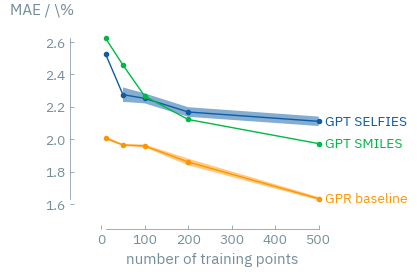

In [9]:
# with plt.style.context(matplotx.styles.dufte):
fig, ax = plt.subplots(1, 1)
ax.plot(
    compiled_grouped_res.loc["SELFIES", :].index,
    compiled_grouped_res.loc["SELFIES", :]["mae"]["mean"],
    label="GPT SELFIES",
    marker="o",
)

ax.fill_between(
    compiled_grouped_res.loc["SELFIES", :].index,
    compiled_grouped_res.loc["SELFIES", :]["mae"]["mean"]
    - compiled_grouped_res.loc["SELFIES", :]["mae"]["sem"],
    compiled_grouped_res.loc["SELFIES", :]["mae"]["mean"]
    + compiled_grouped_res.loc["SELFIES", :]["mae"]["sem"],
    alpha=.5
)

ax.plot(
    compiled_grouped_res.loc["SMILES", :].index,
    compiled_grouped_res.loc["SMILES", :]["mae"]["mean"],
    label="GPT SMILES",
    marker="o",
)

ax.fill_between(
    compiled_grouped_res.loc["SMILES", :].index,
    compiled_grouped_res.loc["SMILES", :]["mae"]["mean"]
    - compiled_grouped_res.loc["SMILES", :]["mae"]["sem"],
    compiled_grouped_res.loc["SMILES", :]["mae"]["mean"]
    + compiled_grouped_res.loc["SMILES", :]["mae"]["sem"],
    alpha=0.5,
)

ax.plot(
    compiled_gpr_grouped.loc[:].index,
    compiled_gpr_grouped["mae"]["mean"],
    label="GPR baseline",
    marker="o",
)

ax.fill_between(
    compiled_gpr_grouped.loc[:].index,
    compiled_gpr_grouped.loc[:]["mae"]["mean"] - compiled_gpr_grouped.loc[:]["mae"]["sem"],
    compiled_gpr_grouped.loc[:]["mae"]["mean"] + compiled_gpr_grouped.loc[:]["mae"]["sem"],
    alpha=0.5,
)

matplotx.line_labels()

ax.set_xlabel("number of training points", labelpad=4)
ylabel_top("MAE / \%", y_pad=-0.05, x_pad=0.02)
# ax.set_xscale('log')

range_frame(
    ax, 
     compiled_gpr_grouped.loc[:].index,
     np.nan_to_num(np.stack(
        [    compiled_gpr_grouped.loc[:]["mae"]["mean"], 
        compiled_grouped_res.loc["SMILES", :]["mae"]["mean"]
        ]
     ).flatten(), 1.7)
)

fig.savefig("opv_regression_res.pdf", bbox_inches="tight")